# Assignment 1: Time Series Analysis - Air Quality

## Author: Fabrizio De Castelli

### 1. Data Preprocessing
Some basic data preprocessing to prepare the dataset for the analysis.
#### 1.1 Load the dataset drop useless columns
The dataset is loaded and the columns are filtered to keep only the sensors and the ground truths. The ground truths are the columns with the suffix 'GT'. The sensors are the columns with the suffix 'S' followed by a number.
All columns have been converted to float and the missing values have been replaced with None. The NMHC(GT) column has been dropped as it contains too many missing values.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the dataset
df = pd.read_csv('dataset/AirQualityUCI.csv', sep=';')
df = df.replace(",", ".", regex=True)

# ground truths
ground_truths = df.filter(regex='(GT)')
ground_truths = ground_truths.astype(float)
ground_truths = ground_truths.replace(-200, None)

# drop NMHC(GT) column as there are too many missing values
ground_truths = ground_truths.drop(columns=['NMHC(GT)'])

# sensors
sensors = df.filter(regex='S\d')
sensors = sensors.replace(-200, None)

# show columns with missing values and their number in a dataframe 
missing_values = ground_truths.isin([None]).sum()
missing_values = pd.concat([missing_values, sensors.isin([None]).sum()])
missing_values

CO(GT)           1684
C6H6(GT)          366
NOx(GT)          1639
NO2(GT)          1642
PT08.S1(CO)       366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
dtype: int64

#### 1.2 Impute missing values
Linear interpolation is used to impute missing values. This is done by taking the mean of the previous and next value.

#### 1.3 Standardize the dataset
The dataset is standardized by subtracting the mean and dividing by the standard deviation of each column.

In [27]:
def imputation(dataframe):
    """
    Impute missing values with the mean of the previous and next value.
    Done via linear interpolation.
    
    :param dataframe: the dataframe to impute
    :return: the imputed dataframe
    """
    for column in dataframe.columns[dataframe.isin([None]).any()]:
        dataframe[column] = dataframe[column].astype(float).interpolate()
    return dataframe

def standardization(dataframe):
    """
    Standardize the dataframe.
    
    :param dataframe: the dataframe to standardize
    :return: the standardized dataframe
    """
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].astype(float)
        dataframe[column] = (dataframe[column] - dataframe[column].mean()) / dataframe[column].std()
    return dataframe

sensors = imputation(sensors)
# sensors = standardization(sensors)
ground_truths = imputation(ground_truths)
ground_truths = standardization(ground_truths)
    
# assert that there are no missing values 
assert sensors.isin([None]).sum().sum() == 0
assert ground_truths.isin([None]).sum().sum() == 0

#### 1.4 Statistics: starting and ending day and time of measurements
To better understand the upcoming analysis, it is important to know the starting and ending day and time of the measurements. The first measurement has been done in the rush hour (traffic peak): the sensors can capture pollution the most.

In [28]:
print(f'Measurements starting day: {df["Date"].iloc[df["Date"].first_valid_index()]}, '
      f'time {df["Time"].iloc[df["Time"].first_valid_index()]}')
print(f'Measurements ending day: {df["Date"].iloc[df["Date"].last_valid_index()]}, '
        f'time {df["Time"].iloc[df["Time"].last_valid_index()]}')

Measurements starting day: 10/03/2004, time 18.00.00
Measurements ending day: 04/04/2005, time 14.00.00


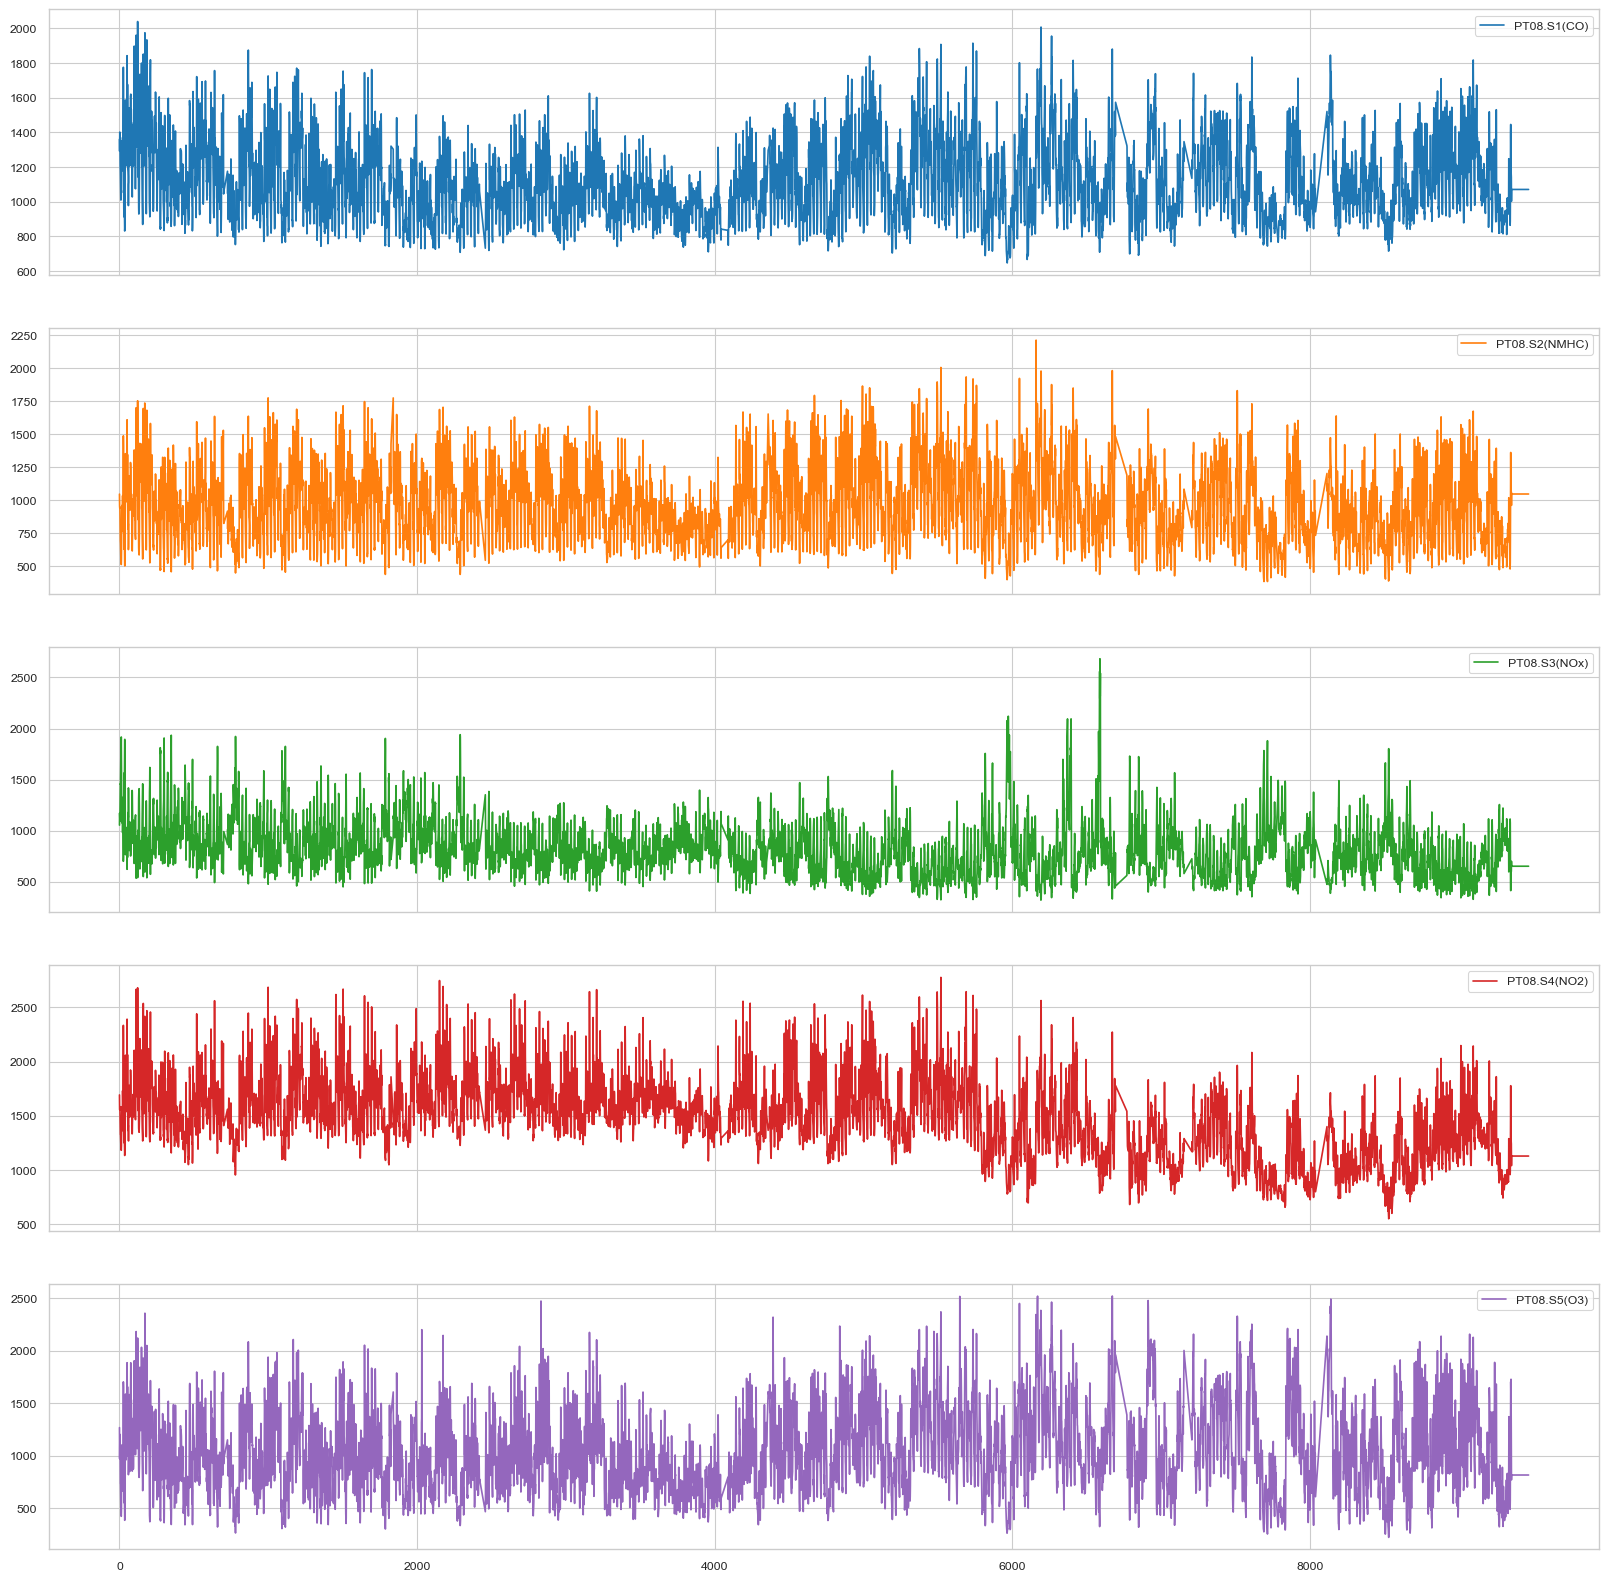

In [ ]:
sensors.plot(subplots=True, figsize=(20, 20))
plt.show()

In [ ]:
ground_truths.plot(subplots=True, figsize=(20, 20))
plt.show()

### 2. Cross-Correlation
Cross-correlation: measure of similarity between two time series as a function of the lag of one relative to the other. It is defined as:

$$
\phi_{x_1x_2}(\tau) = \sum_{t=\max(0, \tau)}^{N + \min(\tau , 0) - 1} x_1(t - \tau)x_2(t)
$$

where $\tau$ is the lag, $N$ is the length of the time two time series, $x_1_t$ and $x_2_t$ are the time series, and $\bar{x_1}$ and $\bar{x_2}$ are the means of the time series. 
The normalized cross-correlation is defined as:

$$
\bar{\phi}_{x_1x_2}(\tau) = \frac{\phi_{x_1x_2}(\tau)}{\sqrt{{\displaystyle \sum_{t=1}^{N}} (x_t)^2} \sqrt{{\displaystyle \sum_{t=1}^{N}} (y_t)^2}}
$$


In [31]:
def normalized_cross_correlation(x, y, lag):
    """
    Computes the normalized cross-correlation between two time series, for a given lag.
    
    :param x: the first time series
    :param y: the second time series
    :param lag: the lag
    :return: the normalized cross-correlation
    """
    return cross_correlation(x, y, lag) / (np.linalg.norm(x) * np.linalg.norm(y))

def cross_correlation(x, y, lag):
    """
    Computes the cross-correlation between two time series, for a given lag.
    
    :param x: the first time series
    :param y: the second time series
    :param lag: the lag
    :return: the cross-correlation
    """
    range_ = slice(max(0, lag), min(len(x), len(x) + lag))
    return np.dot(np.roll(x, -lag)[range_], y[range_])
    

def plot_cross_correlation(dataframe, lags):
    """
    Plots the cross-correlation between all the columns of the dataframe.
    
    :param dataframe: the dataframe
    :param lags: the lags
    """
    
    for i, column1 in enumerate(dataframe.columns):
        for j, column2 in enumerate(dataframe.columns):
            if column1 == column2 or i > j:
                continue
            correlations = [
                normalized_cross_correlation(dataframe[column1], dataframe[column2], lag) 
                for lag in lags
            ]
            
            # plot with seaborn
            plt.figure(figsize=(10, 5))
            sns.set_context('paper')
            sns.set_style('whitegrid')
            sns.lineplot(x=lags, y=correlations)
            plt.title(f'{column1} vs {column2}')
            plt.xlabel('Lag')
            plt.ylabel('Cross - Correlation')
            plt.axhline(0, color='red', lw=1, linestyle='--')
            for k in range(-num_weeks, num_weeks + 1):
                plt.axvline(k * week_hours, color='black', lw=1, linestyle='--')
            if "GT" in column1:
                path = 'results/ground_truths'
            else:
                path = 'results/sensors'
            plt.savefig(f'{path}/{column1}_vs_{column2}.png')
            plt.show()
            plt.close()

### 3. Results
#### 3.1 Cross-Correlation between all pair of sensors
All the sensors seem to be correlated with each other. This is expected as they are measuring air pollution in a similar way. The correlation is stronger when the lag is a multiple of 24 hours, which is expected as the measurements are taken every hour. These peaks appear during the rush hour and are due to the increase in traffic and therefore pollution in the air. The rush hour in which sensors can capture pollution the most is at 18.00 pm, time at which the people are supposed to be returning home from work. 

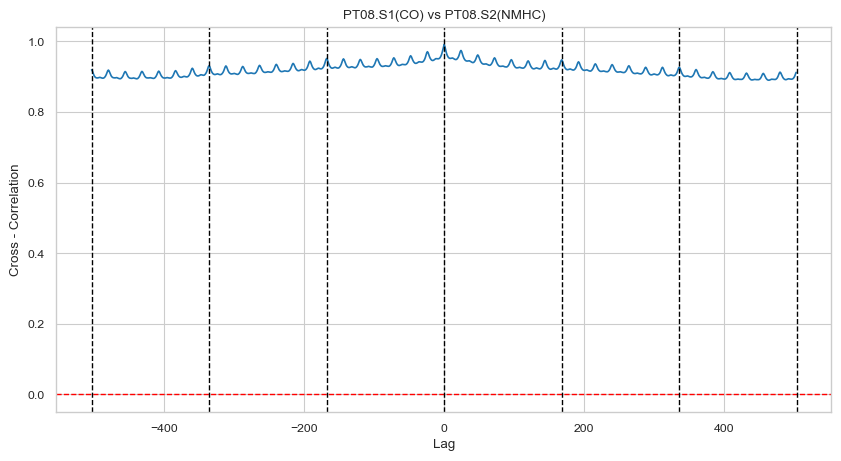

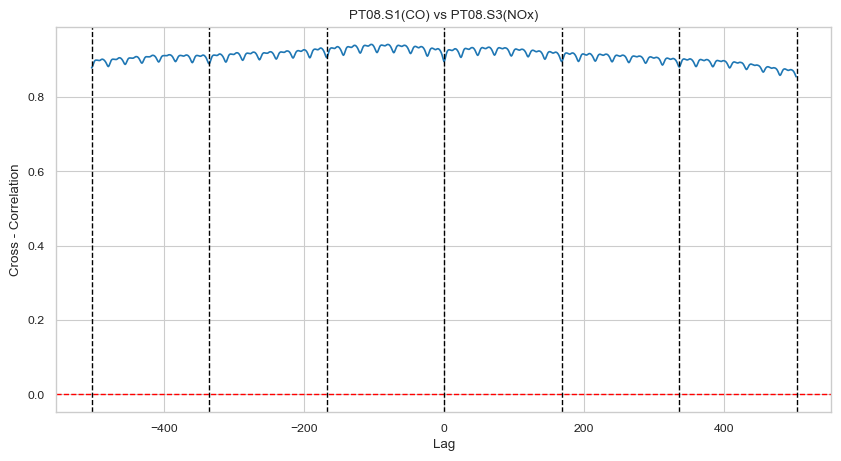

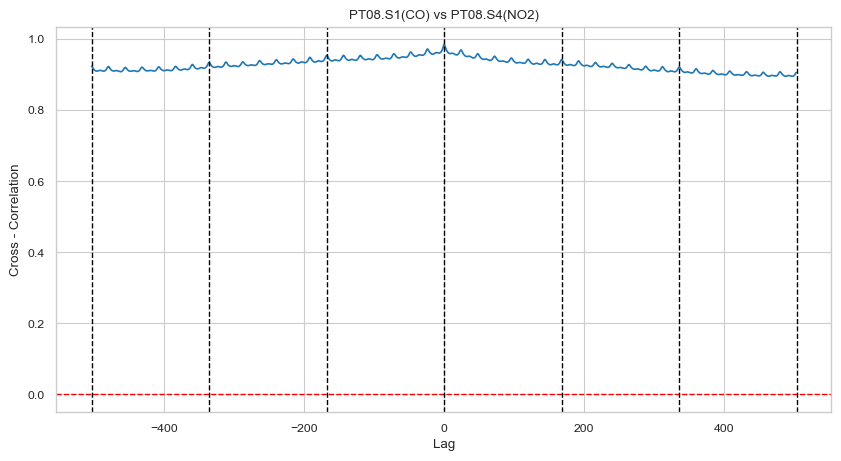

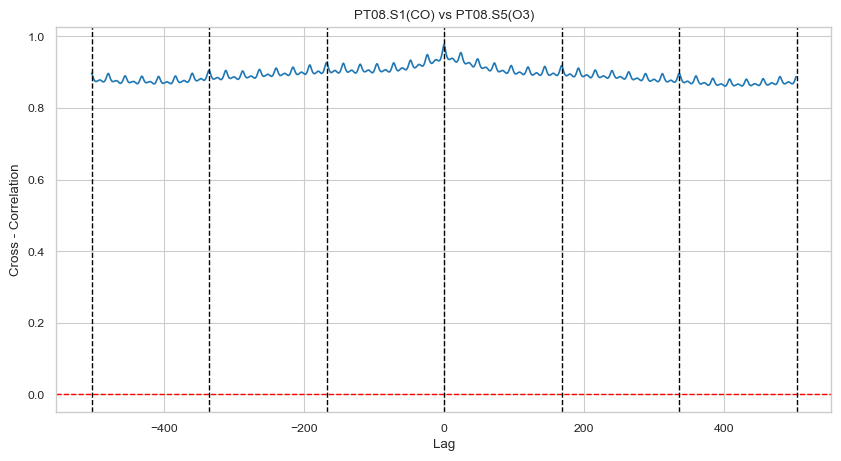

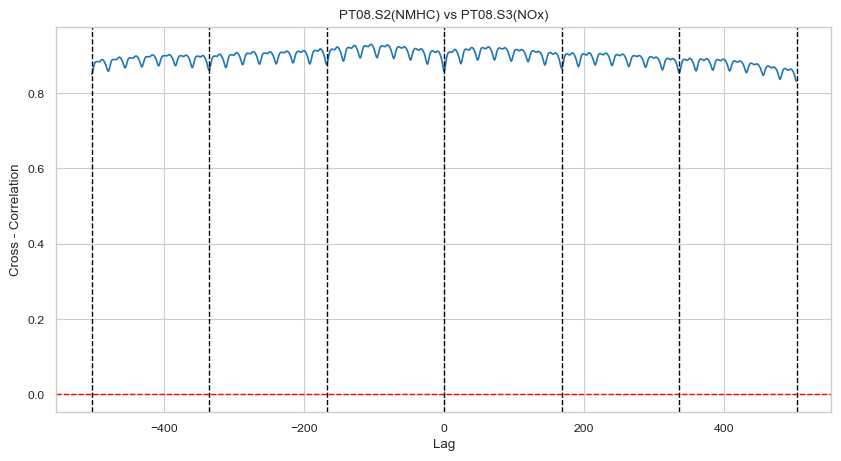

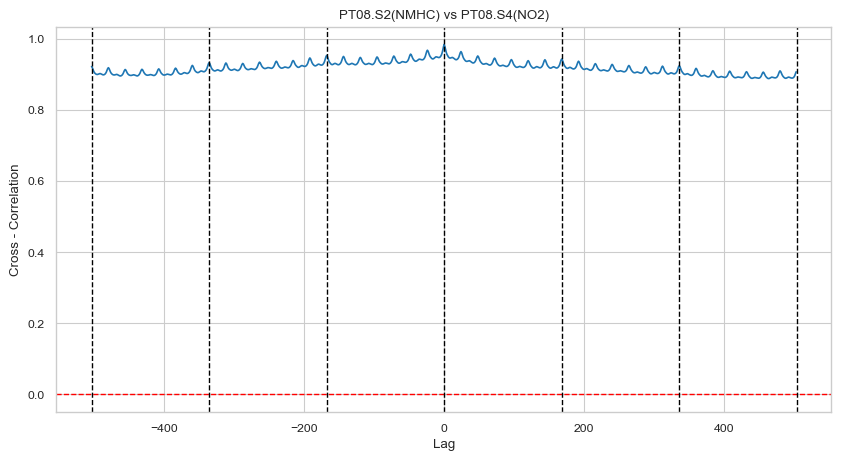

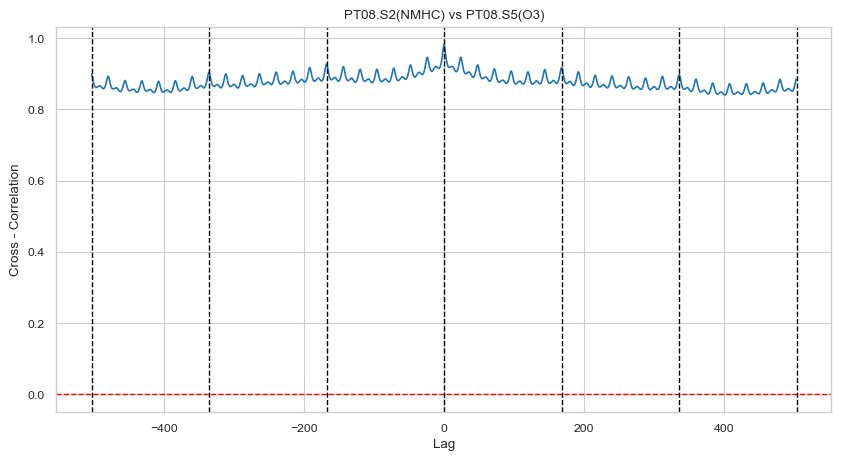

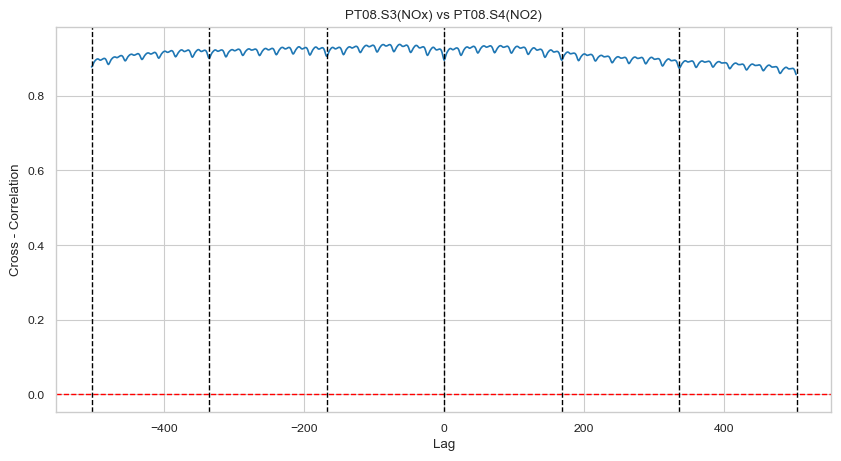

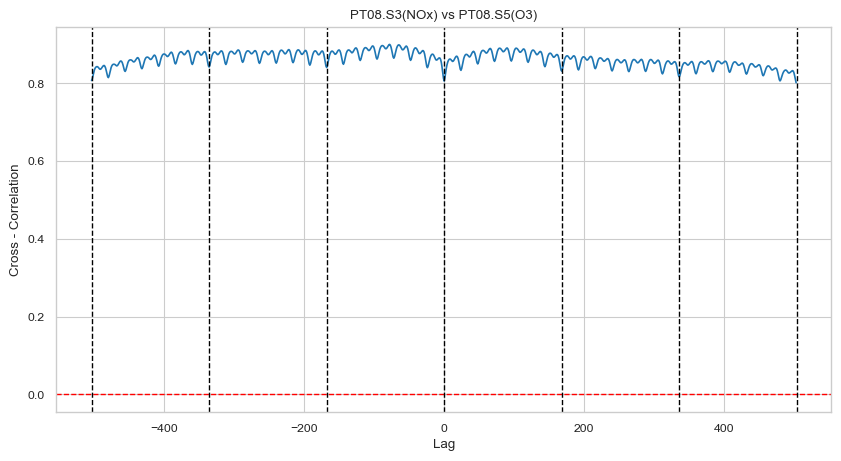

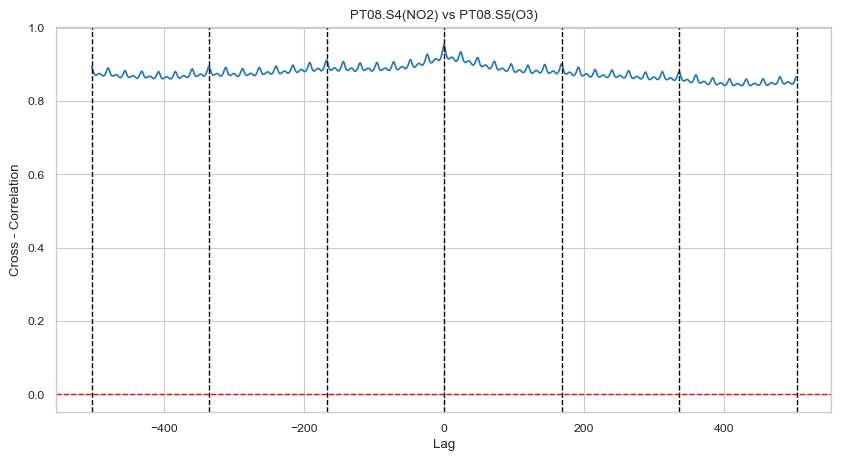

In [34]:
week_hours = 7 * 24
num_weeks = 3
# taus = range(-sensors.shape[0], sensors.shape[0])
taus = range(-num_weeks * week_hours, num_weeks * week_hours)
            
plot_cross_correlation(sensors, taus)

#### 3.2 Cross-Correlation between all pair of ground truths
The ground truths are also correlated with each other. The correlation is stronger when the lag is a multiple of 24 hours, which is expected as the measurements are taken every hour. The peaks are due to the same reason as the sensors. The plots express the same information as the sensors, but the correlation is a little bit weaker. This is expected for two reasons:
1. The ground truths are a de-noised version of the sensors, so some information is lost.
2. The dataset preprocessing involved the handling of many missing values, which could have affected the correlation.

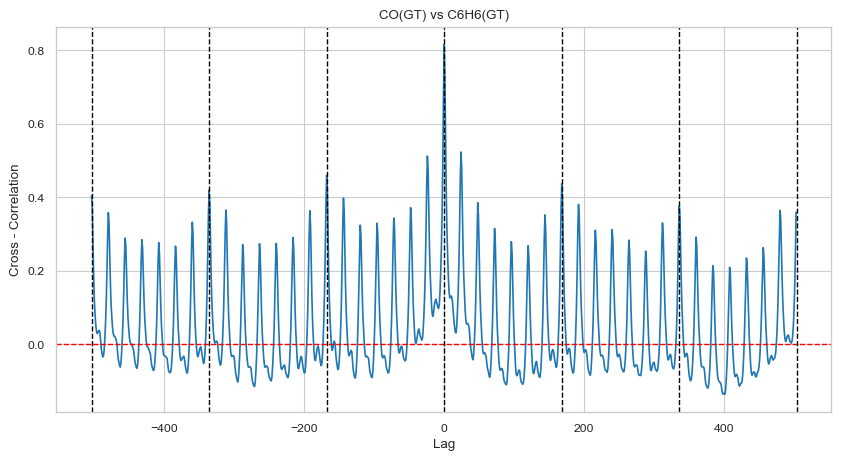

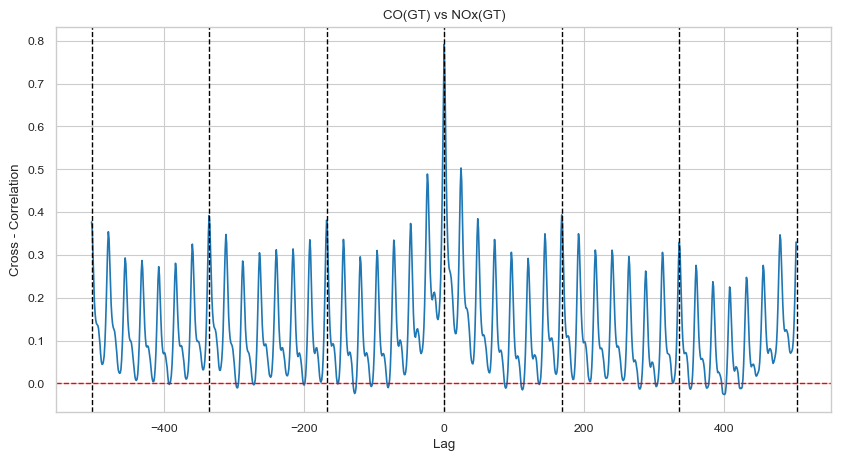

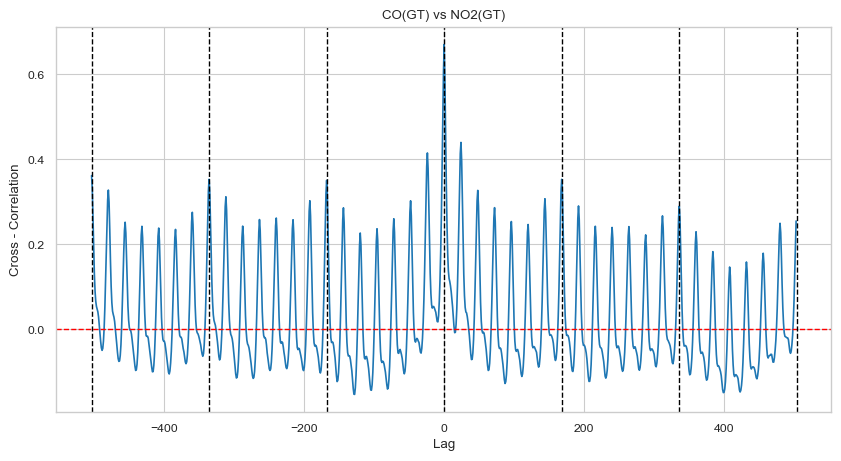

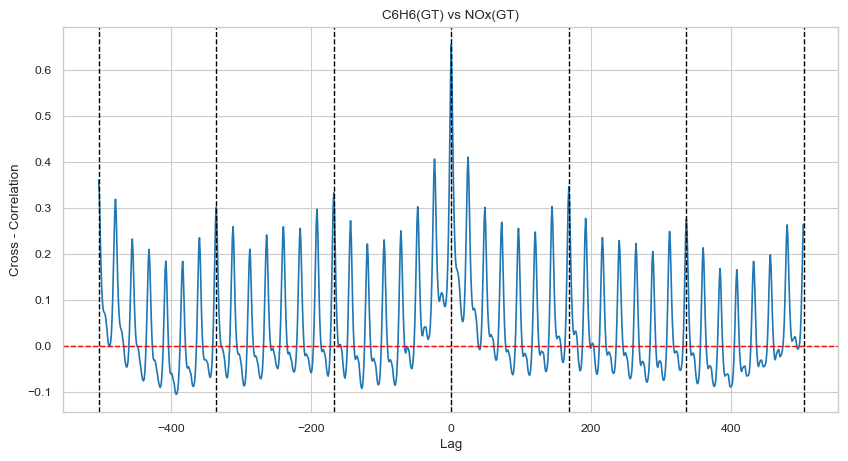

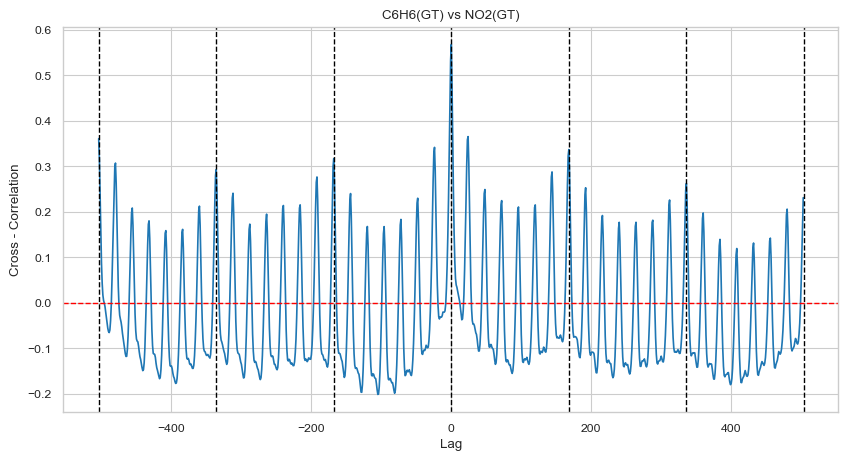

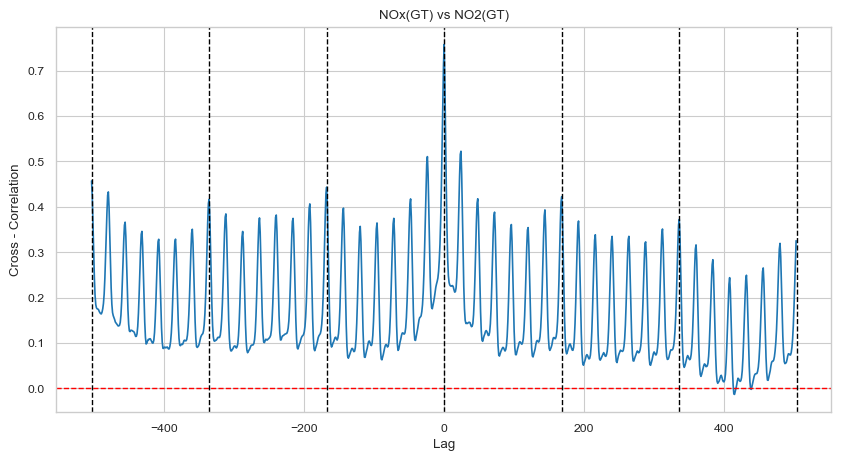

In [35]:
week_hours = 7 * 24
num_weeks = 3
# taus = range(-sensors.shape[0], sensors.shape[0])
taus = range(-num_weeks * week_hours, num_weeks * week_hours)

plot_cross_correlation(ground_truths, taus)
